In [77]:

import numpy as np
import segyio
import matplotlib.pyplot as plt
import ipywidgets as widgets

import matplotlib

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

#%matplotlib inline
%matplotlib notebook
sourcefile='D:/small.sgy'
sourcefile='D:/Vawn.SGY'



def readsegy(sourcefile):
    src=segyio.open(sourcefile)
    a=[]
    for inline in src.ilines:
        a.append(np.array(src.iline[inline]).T)
    a=np.array(a)
    a=np.swapaxes(a,0,1)
    return(a)

   
src=segyio.open(sourcefile)


def il_plot(inline,cmap,interp_method,changecmap=False):
    #inline=inline['new']
    t=np.array(src.iline[inline]).T
    plt.figure('inline')
    if changecmap:
        plt.clf()        
    plt.imshow(t,cmap=cmap,interpolation=interp_method)
    if changecmap:
        plt.colorbar()
    
    #plt.title='inline='+str(inline)
    
    
    
def xl_plot(xline,cmap,interp_method,changecmap=False):
    #xline=xline['new']
    t=np.array(src.xline[xline]).T
    plt.figure('Xline')
    if changecmap:
        plt.clf()
    plt.imshow(t,cmap=cmap,interpolation=interp_method)
    if changecmap:
        plt.colorbar()

    
    
def z_plot(z,cmap,interp_method,changecmap=False):
    #xline=xline['new']
    t=np.array(src.depth_slice[z])
    plt.figure('Time Slice')
    if changecmap:
        plt.clf()
    plt.imshow(t,cmap=cmap,interpolation=interp_method)
    if changecmap:
        plt.colorbar()
    



    
    
def plottm(tmp):
    #print(tmp)
    inline=il_Slider.value
    xline=xl_Slider.value
    print(inline,xline)
    
    t1=np.array(src.iline[inline]).T
    t2=np.array(src.xline[xline]).T
    plt.imshow(t1)
    plt.show()
    plt.imshow(t2)
    
    
    #t3=np.array(src.iline[xline]).T
    
#    fig, axs = plt.subplots(2, 1, constrained_layout=True)
#    fig.suptitle('inline and cross line for '+sourcefile, fontsize=16)
#    
#    axs[0].imshow(t1)
#    axs[0].set_title('inline='+str(inline))
#    #axs[0].set_xlabel('distance (m)')
#    #axs[0].set_ylabel('Damped oscillation')
#    
#
#    axs[1].imshow(t2)
#    axs[1].set_title('xnline='+str(xline))
#    
#    #axs[1].set_xlabel('time (s)')
#    #axs[1].set_ylabel('Undamped')
#
#    plt.show()
    
#plottm(0)
#il_plot(10)
#xl_plot(10)
#src.samples
#z_plot(src.samples[0])

In [78]:
#np_s=readsegy(sourcefile)

il_min=src.ilines[0]
il_max=src.ilines[-1]

xl_min=src.xlines[0]
xl_max=src.xlines[-1]

#print(src.samples)


In [84]:

#il_Slider= widgets.IntSlider(min=il_min,max=il_max,description='Inline')
def on_value_change(change):  
    
    if change['owner'].description=='Inline':
        #print('il=',change['owner'].value)
        il_plot(change['owner'].value,colormap.value,interpolation.value)
    elif change['owner'].description=='Xline':
        #print('xl',change['owner'].value)
        xl_plot(change['owner'].value,colormap.value,interpolation.value)
    elif change['owner'].description=='Zline':
        #print(change['owner'].index)
        z_plot(change['owner'].index,colormap.value,interpolation.value)
    elif change['owner'].description=='Colormap' :
        il_plot(il_Slider.value,colormap.value,interpolation.value,changecmap=True)
        xl_plot(xl_Slider.value,colormap.value,interpolation.value,changecmap=True)
        z_plot(z_Slider.index,colormap.value,interpolation.value,changecmap=True)
    elif  change['owner'].description=='interpolation':
        il_plot(il_Slider.value,colormap.value,interpolation.value)
        xl_plot(xl_Slider.value,colormap.value,interpolation.value)
        z_plot(z_Slider.index,colormap.value,interpolation.value)
    else:    
        print('none')
    #plottm(change)


il_Slider= widgets.SelectionSlider(options=src.ilines,description='Inline')
il_Slider.observe(on_value_change, names='value')



xl_Slider= widgets.SelectionSlider(options=src.xlines,description='Xline')
xl_Slider.observe(on_value_change, names='value')

z_Slider= widgets.SelectionSlider(options=src.samples,description='Zline')#,continuous_update=False
z_Slider.observe(on_value_change, names='value')

colormap=widgets.Dropdown(
    options=['viridis', 'plasma', 'inferno', 'magma', 'cividis','Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn','binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink','spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu','RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic','twilight', 'twilight_shifted', 'hsv','Pastel1', 'Pastel2', 'Paired', 'Accent','Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c','flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern','gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg','gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'
            ],
    value='seismic',
    description='Colormap',
    disabled=False,
)
colormap.observe(on_value_change,names=['value'])


interpolation=widgets.Dropdown(
    options=['nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos'],
    value='nearest',
    description='interpolation',
    disabled=False,
)
interpolation.observe(on_value_change,names=['value'])


SelectionSlider(description='Inline', index=47, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…

Dropdown(description='Colormap', index=50, options=('viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys…

Dropdown(description='interpolation', index=2, options=('nearest', 'bilinear', 'bicubic', 'spline16', 'spline3…

<IPython.core.display.Javascript object>


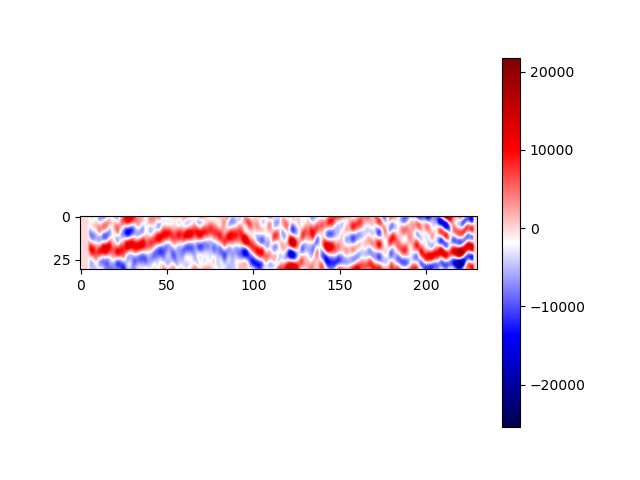

SelectionSlider(description='Xline', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

Dropdown(description='Colormap', index=50, options=('viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys…

Dropdown(description='interpolation', index=2, options=('nearest', 'bilinear', 'bicubic', 'spline16', 'spline3…

<IPython.core.display.Javascript object>


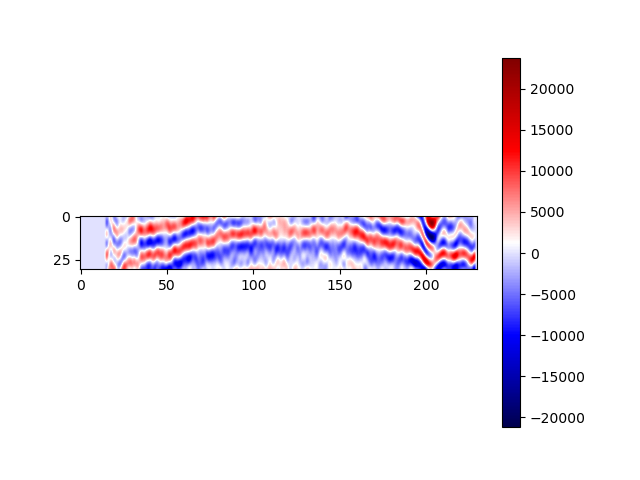

SelectionSlider(description='Zline', options=(-70.0, -69.0, -68.0, -67.0, -66.0, -65.0, -64.0, -63.0, -62.0, -…

Dropdown(description='Colormap', index=50, options=('viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys…

Dropdown(description='interpolation', index=2, options=('nearest', 'bilinear', 'bicubic', 'spline16', 'spline3…

<IPython.core.display.Javascript object>


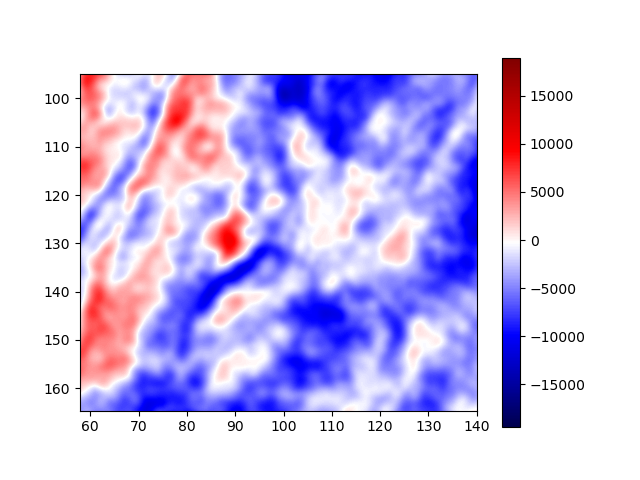

In [86]:

display(il_Slider,colormap,interpolation)
il_plot(src.ilines[0],colormap.value,interpolation.value,changecmap=True)
display(xl_Slider,colormap,interpolation)
xl_plot(src.xlines[0],colormap.value,interpolation.value,changecmap=True)
display(z_Slider,colormap,interpolation)
z_plot(0,colormap.value,interpolation.value,changecmap=True)